<a href="https://colab.research.google.com/github/luuquangtrung/networkx_fat_tree/blob/master/networkx_fat_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install necessary libraries

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import gym
from collections import deque

In [0]:
# Install NetworkX
# !pip install networkx
# !pip install --upgrade networkx

import networkx as nx

In [0]:
# Run NetworkX test (uncomment it)
# nx.test()

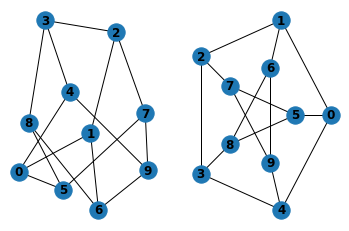

In [0]:
# Do a quick test on NetworkX

Gtest = nx.petersen_graph()

plt.subplot(121)
nx.draw(Gtest, with_labels=True, font_weight='bold')

plt.subplot(122)
nx.draw_shell(Gtest, nlist=[range(5, 10), range(5)], with_labels=True, font_weight='bold')

plt.show()

## Fat-tree topology implementation with NetworkX

0 and 0
1 and 1
2 and 2
3 and 3


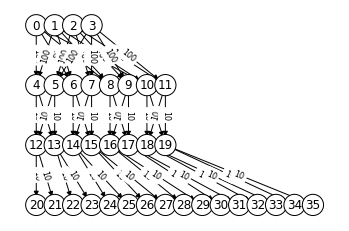

In [0]:
# Class for node layer
class NodeLayer(object):
	def __init__(self, Num, Id, X, Y):
		self.Num = Num
		self.Id = Id
		self.X = X
		self.Y = Y

# Class for infrastructure resource
class Infra(object):
	def __init__(self):
		# Order: CORE - AGGR - EDGE - HOST (BS)
		self.CPU 	= [64, 16, 4, 2]
		self.STO 	= [240, 32, 4, 1.25]
		self.WIRE 	= [0, 0, 0, 10]
		self.BW 	= [100, 10, 10]


infra = Infra()

      
# Generate infrastructure
def fGenInfra():


	UNIT_COST = 1; # Set unit cost
  
	'''
	Initialization
	'''
	s = []     # Start points
	t = []     # Termination points
    
	# Core-Aggr link  
	linkCoreAggr_s = []   
	linkCoreAggr_t = []   

	# Aggr-Edge link 
	linkAggrEdge_s = []   
	linkAggrEdge_t = []   

	# Edge-Host link
	linkEdgeHost_s = []   
	linkEdgeHost_t = []   

	if k == 2:
		# Switch number at each layer
		num_core = 2
		num_aggr = 4
		num_edge = 4
		num_host = 8

		# Create each NodeLayer(Num, Id, X, Y)
		core = NodeLayer(num_core, 
						np.arange(num_core),
						np.arange(num_core), 
						4*np.ones(num_core, dtype = int))

		aggr = NodeLayer(num_aggr, 
						np.arange(num_core, num_core+num_aggr),
						np.arange(num_aggr), 
						3*np.ones(num_aggr, dtype = int))

		edge = NodeLayer(num_edge, 
						np.arange(num_core+num_aggr, num_core+num_aggr+num_edge),
						np.arange(num_edge), 
						2*np.ones(num_edge, dtype = int))

		host = NodeLayer(num_host, 
						np.arange(num_core+num_aggr+num_edge, num_core+num_aggr+num_edge+num_host),
						np.arange(num_host), 
						1*np.ones(num_host, dtype = int))

		# Link connections
		s = [0,0,1,1, 2,2,3,3,4,4,5,5, 6,6,7,7,8,8,9,9]
		t = [2,4,3,5, 6,7,6,7,8,9,8,9, 10,11,12,13,14,15,16,17]

		# Core-Aggr link
		linkCoreAggr_s = [0,0,1,1, 2,4,3,5]							
		linkCoreAggr_t = [2,4,3,5, 0,0,1,1]								

		# Aggr-Edge link 
		linkAggrEdge_s	= [2,2,3,3,4,4,5,5, 6,7,6,7,8,9,8,9]
		linkAggrEdge_t	= [6,7,6,7,8,9,8,9, 2,2,3,3,4,4,5,5]

		# Edge-Host link
		linkEdgeHost_s	= [6,6,7,7,8,8,9,9, 10,11,12,13,14,15,16,17]
		linkEdgeHost_t	= [10,11,12,13,14,15,16,17, 6,6,7,7,8,8,9,9]   

	else:
		# Switch number at each layer
		num_core = (k**2)//4
		num_aggr = (k**2)//2
		num_edge = (k**2)//2
		num_host = (k**3)//4

		# Create each NodeLayer(Num, Id, X, Y)
		core = NodeLayer(num_core, 
						np.arange(num_core),
						np.arange(num_core), 
						4*np.ones(num_core, dtype = int))

		aggr = NodeLayer(num_aggr, 
						np.arange(num_core, num_core+num_aggr),
						np.arange(num_aggr), 
						3*np.ones(num_aggr, dtype = int))

		edge = NodeLayer(num_edge, 
						np.arange(num_core+num_aggr, num_core+num_aggr+num_edge),
						np.arange(num_edge), 
						2*np.ones(num_edge, dtype = int))

		host = NodeLayer(num_host, 
						np.arange(num_core+num_aggr+num_edge, num_core+num_aggr+num_edge+num_host),
						np.arange(num_host), 
						1*np.ones(num_host, dtype = int))

     
        # Edge-Host link
		for x in range(num_edge):
			for y in range(k//2):

				EH_s = edge.Id[x]
				EH_t = host.Id[y+(k//2)*x]

				s.append(EH_s)
				t.append(EH_t)

				linkEdgeHost_s.append(EH_s)
				linkEdgeHost_t.append(EH_t)

		# Core-Aggr-Edge link
		for x in range(k):
			for y in range(k//2):
				for z in range(k//2):
					# Aggr to Edge
					AE_s = aggr.Id[y+(k//2)*x]
					AE_t = edge.Id[z+(k//2)*x]

					linkAggrEdge_s.append(AE_s)
					linkAggrEdge_t.append(AE_t)

					# Core to Aggr
					CA_s = core.Id[z+(k//2)*y]
					CA_t = aggr.Id[y+(k//2)*x]

					linkCoreAggr_s.append(CA_s)
					linkCoreAggr_t.append(CA_t)

					# Append to s and t
					s.extend([AE_s, CA_s])
					t.extend([AE_t, CA_t])


	# Total nb of nodes
	list_nodes = np.arange(num_core+num_aggr+num_edge+num_host)

	# Total nb of edges
	num_linkCoreAggr = len(linkCoreAggr_s)
	num_linkAggrEdge = len(linkAggrEdge_s)
	num_linkEdgeHost = len(linkEdgeHost_s)

	# print(list_nodes)


	'''
	CREATE INFRASTRUCTURE GRAPH Gs
	'''

	Gs = nx.DiGraph()

	# Add nodes
	Gs.add_nodes_from(list_nodes)

	# Add Core-Aggr links
	for i in range(num_linkCoreAggr):
		Gs.add_edge(linkCoreAggr_s[i], linkCoreAggr_t[i], weight=infra.BW[0])


	# Add Aggr-Edge links
	for i in range(num_linkAggrEdge):
		Gs.add_edge(linkAggrEdge_s[i], linkAggrEdge_t[i], weight=infra.BW[1])

	# Add Edge-Host links
	for i in range(num_linkEdgeHost):
		Gs.add_edge(linkEdgeHost_s[i], linkEdgeHost_t[i], weight=infra.BW[2])

	# Add node coordinates
	for i, ni in enumerate(core.Id):
		Gs.node[ni]['pos'] = (core.X[i], core.Y[i])
		print(str(i) + " and " + str(ni))

	for i, ni in enumerate(aggr.Id):
		Gs.node[ni]['pos'] = (aggr.X[i], aggr.Y[i])

	for i, ni in enumerate(edge.Id):
		Gs.node[ni]['pos'] = (edge.X[i], edge.Y[i])

	for i, ni in enumerate(host.Id):
		Gs.node[ni]['pos'] = (host.X[i], host.Y[i])

	return Gs


# =======================================================================


k = 4
Gs = fGenInfra()

# The positions of each node are stored in a dictionary
node_pos = nx.get_node_attributes(Gs, 'pos')

# The edge weights of each arcs are stored in a dictionary
arc_weight = nx.get_edge_attributes(Gs, 'weight')

# Set node and edge color
node_col 		= ['w' for node in Gs.nodes()]
node_label_col 	= ['k' for node in Gs.nodes()]
edge_col 		= ['k' for node in Gs.edges()]


# Plot graph
showInfraFig = True

if showInfraFig == True:
	# nx.draw(Gs, with_labels=True, font_weight='bold')

	# Draw the nodes
	# nx.draw_networkx(Gs, node_pos, node_color= node_col, node_size=450)
	drw_nodes = nx.draw_networkx_nodes(Gs, node_pos, node_color= node_col, node_size=450)
	drw_nodes.set_edgecolor('k')

	# Draw the node labels
	nx.draw_networkx_labels(Gs, node_pos, font_color='k')

	# Draw the edges
	nx.draw_networkx_edges(Gs, node_pos,edge_color= edge_col)

	# Draw the edge labels
	nx.draw_networkx_edge_labels(Gs, node_pos, edge_color= edge_col, 
		edge_labels=arc_weight, font_size=8)

	# Remove the axis
	plt.axis('off')

	plt.show()



In [0]:
Gs.nodes[0]

{'pos': (0, 4)}